# Cumulative Communication

In [10]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import time
from IPython.display import clear_output
import ipywidgets as widgets
import os
import math

In [11]:
plt.rcParams["figure.figsize"] = (16,8)

In [3]:
dirs = [d for d in sorted(os.listdir('.')) if os.path.isdir(d)]
wFolder = widgets.Dropdown(
    options=dirs,
    description='Experiment:',
)
display(wFolder)

Dropdown(description='Experiment:', options=('.ipynb_checkpoints', 'VGMM_CENTRALIZED_exp_2018-11-21 10-34-05',…

In [33]:
experimentFolder = wFolder.value
print(experimentFolder)

deepDrivingExp_2018-12-04 12-33-03


In [34]:
# amount of folders named "workerN" is amount of local learners
# be careful when running interactively, folders are not created right away - just when the learner is initialized
nodesAmount = 0
dirs = [d for d in os.listdir(experimentFolder) if os.path.isdir(os.path.join(experimentFolder,d))]
for d in dirs:
    if 'worker' in d:
        nodesAmount += 1
print("Learners amount is ", str(nodesAmount))

Learners amount is  9


In [35]:
# get zero timestamp, i.e., beginning of the experiment
expSummary = open(os.path.join(experimentFolder,"summary.txt")).read()
for l in expSummary.split("\n"):
    if "Start" in l:
        startTimestamp = float(l.split("\t")[-1][:-1])
        break

In [36]:
# take only coordinator communication logs, since workers communication logs duplicate them with opposite direction
files = []
for f in os.listdir(os.path.join(experimentFolder, "coordinator", "communication")):
    files.append(open(os.path.join(experimentFolder, "coordinator", "communication", f), "r"))

In [37]:
# setup of the plots saving
displayStep = 1
recordStep = 1
recordUnique = False
uniqueImageCounter = 0
# draw a point for every second of experiment time
frequencyStep = 10

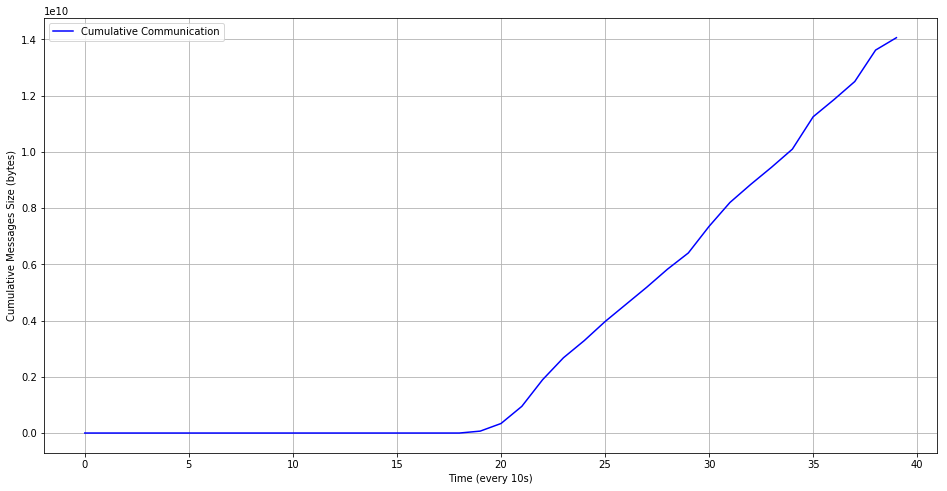

KeyboardInterrupt: 

In [38]:
# we have zero communication at the beginning
plot = [0]
change = False
while True:
    for f in files:
        where = f.tell()
        line = f.readline()
        if line:
            change = True
            parsedLine = line.split("\t")
            lineTimestamp = float(parsedLine[0])
            # identify to which point in time this line will go
            xPoint = math.ceil((lineTimestamp - startTimestamp) / frequencyStep)
            # the send_model log has only 4 elements in line since the learner ids to whom
            # the model was sent are written in the topic, i.e., newModel.0.1.2
            # that is why we need to multiply the size of this message by the amount of learners in the topic
            if len(parsedLine) == 5:
                messagesAmount = parsedLine[2].count(".")
                messageSize = float(parsedLine[3]) * messagesAmount
            else:
                messageSize = float(parsedLine[4])
            # if we do not yet have this point on our axis - add it and all the previous ones
            # the value on all the new points is saved from the last position
            if len(plot) < xPoint:
                for i in range(xPoint - len(plot)):
                    plot.append(plot[-1])
            # now add the message size to all the points that are after the position of this message
            # this can possibly lead to "bumps" on how the plot is growing, but it is the way
            # to read all the files while they are being created
            for i in range(len(plot) - xPoint):
                plot[xPoint + i] += messageSize
          
    # do not need to call plotting if no new lines were read
    if not change:
        time.sleep(1)
        continue
    
    change = False
    if len(plot) % displayStep == 0:
        clear_output(wait=True)
        fig = plt.figure()
        plt.plot(range(len(plot)), plot, label='Cumulative Communication', color='blue')
        plt.legend(loc='upper left')
        plt.xlabel("Time (every " + str(frequencyStep) + "s)")
        plt.ylabel("Cumulative Messages Size (bytes)")
        plt.grid()
        plt.show()
    if len(plot) % recordStep == 0:
        if recordUnique:
            fig.savefig(os.path.join(experimentFolder, 
                                     'cumulative_communication' + str(uniqueImageCounter) + '.png'), dpi=100)
            uniqueImageCounter += 1
        else:
            fig.savefig(os.path.join(experimentFolder, 'cumulative_communication.png'), dpi=100)           

In [39]:
for file in files:
    file.close()